In [ ]:
# ADAPTED FROM EXISTING MNIST DEMO NOTEBOOK

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

from rerf.rerfClassifier import rerfClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Author: Arthur Mensch <arthur.mensch@m4x.org>
# License: BSD 3 clause

# Turn down for faster convergence
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

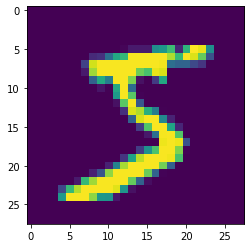

In [3]:
plt.imshow(X[0].reshape((28,28)))

In [4]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [5]:
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [6]:
#clf_rerf = rerfClassifier(projection_matrix="Base", n_jobs=8, n_estimators=100)
ncores = 8
nest = 100
im_height=28
im_width=28
patch_h_min=1
patch_w_min=1
patch_h_max=5
patch_w_max=5

clf_sklearnrf_proj = RandomForestClassifier(n_jobs = ncores, n_estimators = nest)
clf_sklearnrf = RandomForestClassifier(n_jobs = ncores, n_estimators = nest)
clf_MORF = rerfClassifier(projection_matrix="S-RerF",
                             image_height=im_height,
                             image_width=im_width,
                             n_estimators=nest,
                             patch_height_min=patch_h_min,
                             patch_width_min=patch_w_min,
                             patch_height_max=patch_h_max,
                             patch_width_max=patch_w_max,
                             n_jobs=ncores, 
                           )
print(clf_sklearnrf_proj)
print(clf_sklearnrf)
print(clf_MORF)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
rerfClassifier(feature_c

In [11]:
import random
def RandPatchGen(ih, iw, ph_min, ph_max, pw_min, pw_max, num_patches):
    # generate random patch list (height, width, (top_left_row, top_left_col) )
    # param ih: image height (integer)
    # param iw: image width (integer)
    # param ph_min: patch height minimum (integer)
    # param ph_max: patch height maximum (integer)
    # param pw_min: patch width minimum (integer)
    # param pw_max: patch width maximum (integer)
    # param num_patches: desired number of patches (integer)
    # return : list of patches
    
    #Initialize patch descriptors
    deltah = 0
    deltaw = 0
    topLeft = (0,0)
    bottomRight = (0,0)
    
    #generate num_patches patches by randomly choosing 
    #a height, width, and top left coordinate
    patches = []
    for i in range(num_patches):
        # generate random patch height and width
        deltah = random.randint(ph_min, ph_max)
        deltaw = random.randint(pw_min, pw_max)
        
        # generate random patch top left corner by 
        # restricting based on patch height and width
        ih_max = ih - deltah - 1 # original adds 1, not sure why
        iw_max = iw - deltaw - 1 
        #stored as tuple instead of single value
        topLeft = (random.randint(0,ih_max), random.randint(0,iw_max)) 
        
        # store height, width, and top left corner index in patches list
        patches.append((deltah, deltaw, tuple(topLeft))) # do I need to deep copy? 
        
    return patches

def preprojection(X, patches, ih, iw):
    X_cube = X.reshape((len(X), ih, iw))
    X_new =  np.empty((len(X),0), int)
    for patch in patches:
        dh, dw, topLeft = patch
        ystart, xstart = topLeft
        xend = xstart + dw
        yend = ystart + dh
        feat = np.sum(np.sum(X_cube[:, ystart:yend, xstart:xend], axis = 1), axis = 1).reshape((len(X),1))
        X_new = np.append(X_new, feat, axis=1)
    return X_new

In [13]:
patches = RandPatchGen(im_height, im_width, patch_h_min, patch_h_max, patch_w_min, patch_w_max, im_height * im_width * 2)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train_proj = preprojection(X_train, patches, im_height, im_width)
X_test_proj = preprojection(X_test, patches, im_height, im_width)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [21]:
t0 = time.time()
clf_sklearnrf.fit(X_train, y_train)
run_time = time.time() - t0
print("run time sklearnrf raw", run_time)

run time sklearnrf raw 0.6595962047576904


In [22]:
t0 = time.time()
clf_sklearnrf_proj.fit(X_train_proj, y_train)
run_time = time.time() - t0
print("run time sklearnrf projection", run_time)

run time sklearnrf projection 1.5471982955932617


In [23]:
t0 = time.time()
clf_MORF.fit(X_train, y_train)
run_time = time.time() - t0
print("run time MORF", run_time)

run time MORF 6.426556825637817


In [24]:
train_acc_sklearnrf = clf_sklearnrf.score(X_train, y_train)
print("train_acc sklearnrf raw", train_acc_sklearnrf)

train_acc_sklearnrf_proj = clf_sklearnrf_proj.score(X_train_proj, y_train)
print("train_acc sklearnrf projection", train_acc_sklearnrf_proj)

train_acc_MORF = clf_MORF.score(X_train, y_train)
print("train_acc MORF", train_acc_sklearnrf_proj)

train_acc sklearnrf raw 1.0
train_acc sklearnrf projection 1.0
train_acc MORF 1.0


In [26]:
score_sklearnrf = clf_sklearnrf.score(X_test, y_test)
print("score sklearnrf raw", score_sklearnrf)

score_sklearnrf_proj = clf_sklearnrf_proj.score(X_test_proj, y_test)
print("score sklearnrf projection", score_sklearnrf_proj)

score_MORF = clf_MORF.score(X_test, y_test)
print("score MORF", score_MORF)

score sklearnrf raw 0.9373
score sklearnrf projection 0.9429
score MORF 0.9423


In [ ]:
scores_sklearnrf = []
scores_sklearnrf_proj = []
scores_MORF = []
for it in range(100):
    patches = RandPatchGen(im_height, im_width, patch_h_min, patch_h_max, patch_w_min, patch_w_max, im_height * im_width * 2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=10000)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    X_train_proj = preprojection(X_train, patches, im_height, im_width)
    X_test_proj = preprojection(X_test, patches, im_height, im_width)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    clf_sklearnrf.fit(X_train, y_train)
    clf_sklearnrf_proj.fit(X_train_proj, y_train)
    clf_MORF.fit(X_train, y_train)
    
    #train_acc_sklearnrf = clf_sklearnrf.score(X_train, y_train)
    #train_acc_sklearnrf_proj = clf_sklearnrf_proj.score(X_train_proj, y_train)
    #train_acc_MORF = clf_MORF.score(X_train, y_train)
    
    scores_sklearnrf.append(clf_sklearnrf.score(X_test, y_test))
    scores_sklearnrf_proj.append(clf_sklearnrf_proj.score(X_test_proj, y_test))
    scores_MORF.append(clf_MORF.score(X_test, y_test))

scores_sklearnrf = np.array(scores_sklearnrf)
scores_sklearnrf_proj = np.array(scores_sklearnrf_proj)
scores_MORF = np.array(scores_MORF)

In [ ]:
sklearnrf_mean = np.mean(scores_sklearnrf)
sklearnrf_proj_mean = np.mean(scores_sklearnrf_proj)
MORF_mean = np.mean(scores_MORF)
print("Mean Score Sklearn RF Raw: " + str(sklearnrf_mean))
print("Mean Score Sklearn RF Projections: " + str(sklearnrf_proj_mean))
print("Mean Score MORF: " + str(MORF_mean))

sklearnrf_std = np.std(scores_sklearnrf)
sklearnrf_proj_std = np.std(scores_sklearnrf_proj)
MORF_std = np.std(scores_MORF)
print("Score Standard Deviation Sklearn RF Raw: " + str(sklearnrf_std))
print("Score Standard Deviation Sklearn RF Projections: " + str(sklearnrf_proj_std))
print("Score Standard Deviation MORF: " + str(MORF_std))

In [ ]:
import pandas as pd
import seaborn as sns

data = pd.DataFrame(np.array([scores_sklearnrf,scores_sklearnrf_proj, scores_MORF], 
                             columns = ['sklearnrf_raw', 'sklearnrf_proj', 'MORF']))
#f = sns.lineplot(x="Trial", y="Score", hue="split", data=df)